Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detetction/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
true_labels = []
file_paths = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    file_paths.extend(test_ds.file_paths)

# Convert true_labels to a NumPy array
true_labels = np.array(true_labels)


In [11]:
num_classes=len(class_names)
print(num_classes)

9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

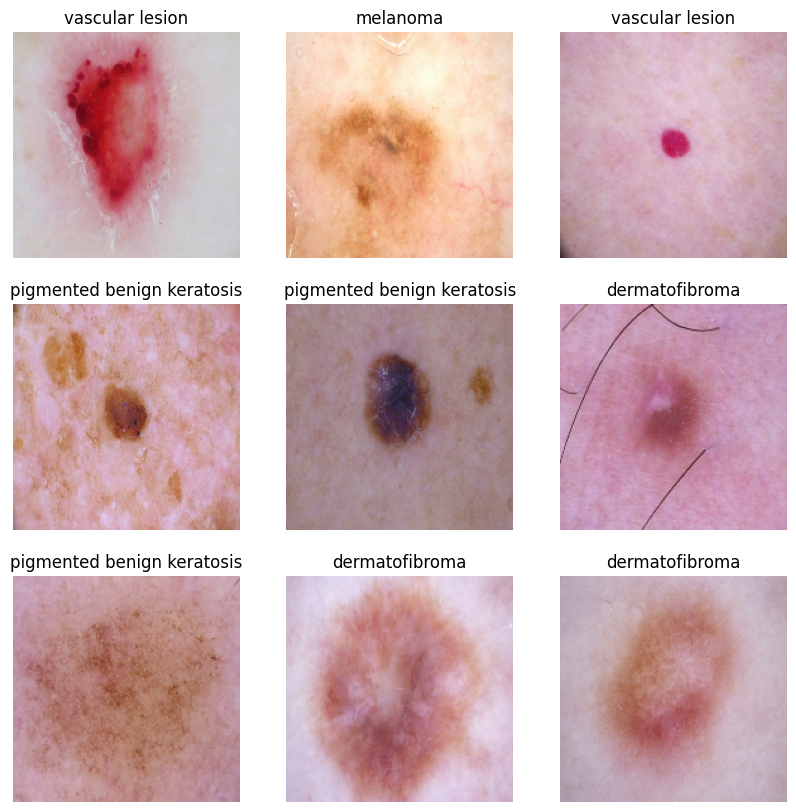

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        3

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
# Adam is the best among the adaptive optimizers in most of the cases
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

In [16]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 116s 520ms/step - loss: 1.9061 - accuracy: 0.2865 - val_loss: 1.5793 - val_accuracy: 0.4047
Epoch 2/20
169/169 [==============================] - 5s 30ms/step - loss: 1.4943 - accuracy: 0.4309 - val_loss: 1.4558 - val_accuracy: 0.4307
Epoch 3/20
169/169 [==============================] - 5s 31ms/step - loss: 1.3329 - accuracy: 0.4900 - val_loss: 1.2516 - val_accuracy: 0.5419
Epoch 4/20
169/169 [==============================] - 5s 31ms/step - loss: 1.1614 - accuracy: 0.5646 - val_loss: 1.1746 - val_accuracy: 0.5508
Epoch 5/20
169/169 [==============================] - 5s 31ms/step - loss: 1.0298 - accuracy: 0.6215 - val_loss: 1.1309 - val_accuracy: 0.5841
Epoch 6/20
169/169 [==============================] - 5s 31ms/step - loss: 0.8604 - accuracy: 0.6809 - val_loss: 1.0444 - val_accuracy: 0.6234
Epoch 7/20
169/169 [==============================] - 5s 32ms/step - loss: 0.7627 - accuracy: 0.7274 - val_loss: 0.9609 - val_accuracy: 0.6

### Visualizing training results

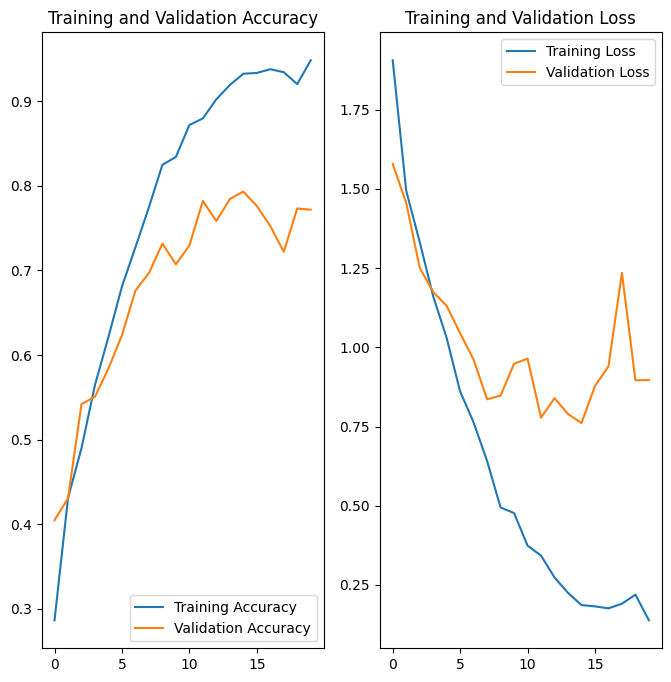

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
predicted_probabilities = model.predict(test_ds)

4/4 [==============================] - 5s 96ms/step


In [19]:
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Calculate the accuracy
accuracy = np.mean(np.equal(true_labels, predicted_classes))

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 13.56%


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The model is overfitted and is evident from the train and validation accuracy. Train accuracy is very high but validation accuracy is very low.

We will use Augmentation and droput alongwith Normalization to see how it reduces the overfitting

In [20]:
# Data Augmention is being used here

datagen = ImageDataGenerator(
    rotation_range=40,
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'
)


Found 6749 images belonging to 9 classes.


In [21]:
# Split the data into training and validation sets
train_generator = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    seed=123,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    seed=123,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 5403 images belonging to 9 classes.
Found 1346 images belonging to 9 classes.


In [22]:
class_labels = train_generator.class_indices
print(class_labels)


{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


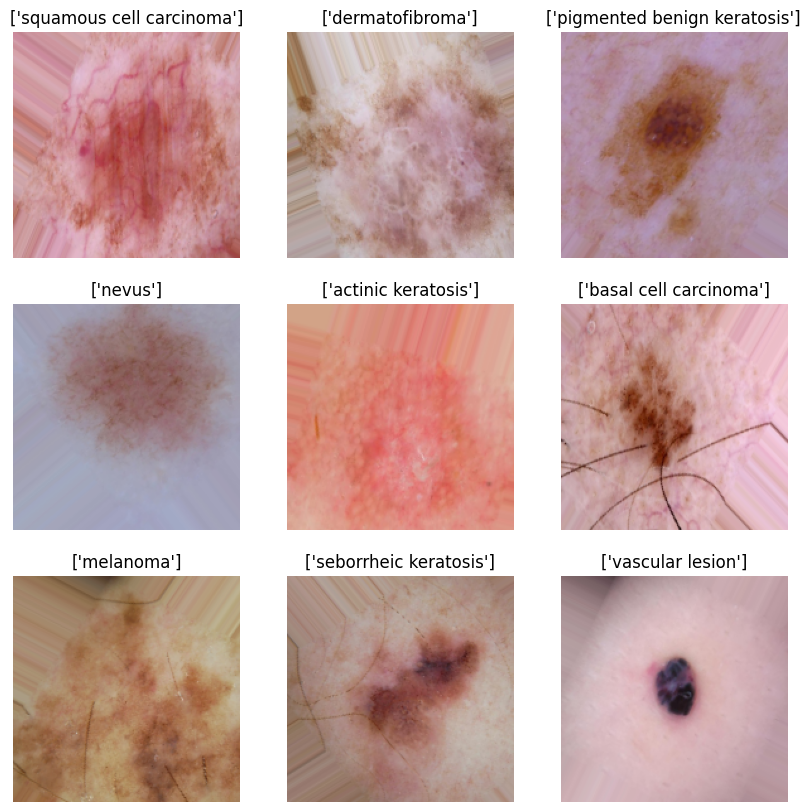

In [23]:
### your code goes here, you can use training or validation data to visualize
# visualize how your augmentation strategy works for one instance of training image.
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
class_labels = np.argmax(labels, axis=1)
class_labels = class_labels.ravel()
cls_plotted_already = []
count=0
for i in range(32):  # Iterate over the samples in the batch
  label = labels[i]  # Get the label for the current sample
  class_labels = np.argmax(labels[i])
  class_labels = class_labels.ravel()
  class_names = [class_name for class_name, class_index in train_generator.class_indices.items() if class_index in class_labels]
  if class_names in cls_plotted_already:
    continue
  cls_plotted_already.append(class_names)
    # Create a subplot for each sample
  ax = plt.subplot(3, 3, count + 1)  # Adjust the subplot grid based on your batch size
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names)
  plt.axis("off")
  count=count+1

plt.show()

### Todo:
### Create the model, compile and train the model


In [24]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

input_shape = (180,180,3)


model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten()) #Do not repeat flatten layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))


### Compiling the model

In [25]:
# Adam is the best among the adaptive optimizers in most of the cases

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [26]:
## Your code goes here
epochs = 20 # As specified in the project pipeline
steps_per_epoch = len(train_generator)  # Number of batches per epoch
validation_steps = len(val_generator)
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/20
169/169 [==============================] - 105s 603ms/step - loss: 1.8790 - accuracy: 0.2760 - val_loss: 1.6270 - val_accuracy: 0.3648
Epoch 2/20
169/169 [==============================] - 98s 581ms/step - loss: 1.5803 - accuracy: 0.3948 - val_loss: 1.5759 - val_accuracy: 0.3782
Epoch 3/20
169/169 [==============================] - 97s 575ms/step - loss: 1.5159 - accuracy: 0.4127 - val_loss: 1.4713 - val_accuracy: 0.4257
Epoch 4/20
169/169 [==============================] - 97s 575ms/step - loss: 1.4298 - accuracy: 0.4573 - val_loss: 1.5140 - val_accuracy: 0.4205
Epoch 5/20
169/169 [==============================] - 97s 573ms/step - loss: 1.4438 - accuracy: 0.4529 - val_loss: 1.4640 - val_accuracy: 0.4116
Epoch 6/20
169/169 [==============================] - 97s 576ms/step - loss: 1.4056 - accuracy: 0.4718 - val_loss: 1.3870 - val_accuracy: 0.4651
Epoch 7/20
169/169 [==============================] - 96s 571ms/step - loss: 1.3751 - accuracy: 0.4792 - val_loss: 1.4371 - val_a

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 64)       

### Visualizing the results

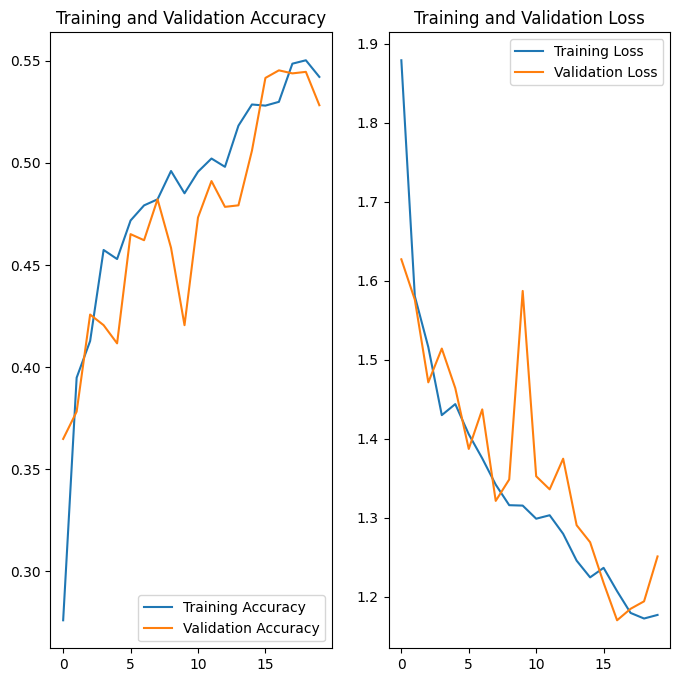

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
dropout_conv=0.05
dropout_dense=0.25

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(9, activation='softmax')
])

In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 64)       

In [32]:
## Your code goes here, note: train your model for 20 epochs
# My model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
169/169 [==============================] - 102s 580ms/step - loss: 1.9391 - accuracy: 0.2560 - val_loss: 1.6508 - val_accuracy: 0.3618
Epoch 2/20
169/169 [==============================] - 98s 581ms/step - loss: 1.6538 - accuracy: 0.3613 - val_loss: 1.5579 - val_accuracy: 0.3952
Epoch 3/20
169/169 [==============================] - 98s 579ms/step - loss: 1.6070 - accuracy: 0.3839 - val_loss: 1.5441 - val_accuracy: 0.3908
Epoch 4/20
169/169 [==============================] - 97s 577ms/step - loss: 1.5635 - accuracy: 0.4035 - val_loss: 1.5665 - val_accuracy: 0.4131
Epoch 5/20
169/169 [==============================] - 116s 688ms/step - loss: 1.5079 - accuracy: 0.4237 - val_loss: 1.4439 - val_accuracy: 0.4257
Epoch 6/20
169/169 [==============================] - 97s 577ms/step - loss: 1.4573 - accuracy: 0.4322 - val_loss: 1.3650 - val_accuracy: 0.4413
Epoch 7/20
169/169 [==============================] - 98s 580ms/step - loss: 1.4299 - accuracy: 0.4509 - val_loss: 1.3922 - val_

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Yes, the model has improved. We still have overfit issue

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

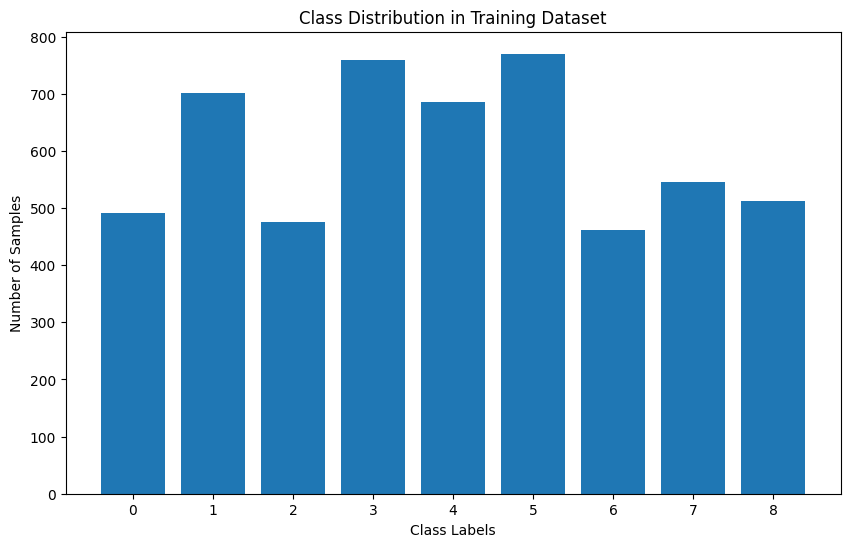

In [33]:
## Your code goes here.
import numpy as np
import matplotlib.pyplot as plt

labels = train_generator.labels

# Count the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Visualize the distribution of class labels
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xticks(unique_labels)
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Dataset")
plt.show()


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis : 6

#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis : 5


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
import Augmentor
import os
import glob

# Create a list of Augmentor.Pipeline objects, one for each class
pipelines = []

# Specify the number of additional images to generate for each class
additional_images_per_class = 500

for class_dir in os.listdir(data_dir_train):
    class_dir_path = os.path.join(data_dir_train, class_dir)
    if os.path.isdir(class_dir_path):
        class_pipeline = Augmentor.Pipeline(source_directory=class_dir_path)

        # # Define augmentations for each class pipeline as needed
        class_pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
        class_pipeline.flip_left_right(probability=0.5)
        class_pipeline.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
        print("source_directory",class_dir_path)
        # Sample additional images for each class
        num_images_in_class = len(glob.glob(os.path.join(class_dir_path, '*.jpg')))
        print("Image avail",num_images_in_class)
        num_samples_to_generate = additional_images_per_class - num_images_in_class
        print("to generate",num_samples_to_generate)
        if num_samples_to_generate > 0:
            class_pipeline.sample(num_samples_to_generate)

        pipelines.append(class_pipeline)

print("Augmentation completed.")


Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Image avail 114
to generate 386


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7988FCDB3E50>: 100%|██████████| 386/386 [00:17<00:00, 22.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Image avail 77
to generate 423


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7989980D1360>: 100%|██████████| 423/423 [00:35<00:00, 11.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Image avail 357
to generate 143


Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7988FCFCCDC0>: 100%|██████████| 143/143 [00:27<00:00,  5.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Image avail 95
to generate 405


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7988F80BF8B0>: 100%|██████████| 405/405 [00:14<00:00, 27.29 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Image avail 181
to generate 319


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79890A35D6C0>: 100%|██████████| 319/319 [00:12<00:00, 25.61 Samples/s]


Initialised with 448 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Image avail 448
to generate 52


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7988FCD93C70>: 100%|██████████| 52/52 [00:08<00:00,  6.20 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Image avail 376
to generate 124


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7988F812B9A0>: 100%|██████████| 124/124 [00:04<00:00, 29.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Image avail 462
to generate 38


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7988F81764D0>: 100%|██████████| 38/38 [00:01<00:00, 29.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.source_directory Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Image avail 139
to generate 361


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7988F2F25F90>: 100%|██████████| 361/361 [00:14<00:00, 25.44 Samples/s]

Augmentation completed.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6751


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_152fa151-3292-4f97-b5fd-8c4ceab62863.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_1343d8ac-a14a-46d3-8f9b-a97e2bf399b3.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_5b867bed-d173-4dd1-a3b7-9655e3ba5eb6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_25e44cc5-9fab-487d-b6f5-b61ae0cb5060.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_41bbf7fb-8daa-490d-9c47-256f05fff5a2.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ou

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [42]:
path_list_old = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_old

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026468.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026212.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026625.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026575.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026457.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025992.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg',
 'Skin cancer ISIC The International 

In [43]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_old

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [44]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [45]:
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [46]:
original_df.count()

Path     2249
Label    2249
dtype: int64

In [47]:
new_df = original_df.append(df2)

<ipython-input-47-2ade1842133b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [48]:
new_df['Label'].value_counts()

actinic keratosis             1000
seborrheic keratosis          1000
nevus                         1000
dermatofibroma                1000
squamous cell carcinoma       1000
melanoma                      1000
basal cell carcinoma          1000
pigmented benign keratosis    1000
vascular lesion               1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [50]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training" ,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9000 files belonging to 9 classes.
Using 7200 files for training.


#### **Todo:** Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [52]:
## your code goes here

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(64, 3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
## your code goes here

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])

#### **Todo:**  Train your model

In [54]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds ,  callbacks=[learning_rate_reduction])

Epoch 1/30
225/225 [==============================] - 53s 213ms/step - loss: 2.7462 - accuracy: 0.2794 - val_loss: 2.1977 - val_accuracy: 0.1144 - lr: 0.0010
Epoch 2/30
225/225 [==============================] - 45s 194ms/step - loss: 1.7908 - accuracy: 0.3460 - val_loss: 2.0495 - val_accuracy: 0.2456 - lr: 0.0010
Epoch 3/30
225/225 [==============================] - 44s 192ms/step - loss: 1.6628 - accuracy: 0.3760 - val_loss: 1.9109 - val_accuracy: 0.3389 - lr: 0.0010
Epoch 4/30
225/225 [==============================] - 44s 190ms/step - loss: 1.5683 - accuracy: 0.4042 - val_loss: 2.1933 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 5/30
225/225 [==============================] - 44s 192ms/step - loss: 1.5129 - accuracy: 0.4192 - val_loss: 1.6079 - val_accuracy: 0.3994 - lr: 0.0010
Epoch 6/30
225/225 [==============================] - 45s 195ms/step - loss: 1.4481 - accuracy: 0.4364 - val_loss: 1.5157 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 7/30
225/225 [==============================] 

### Visualizing the results

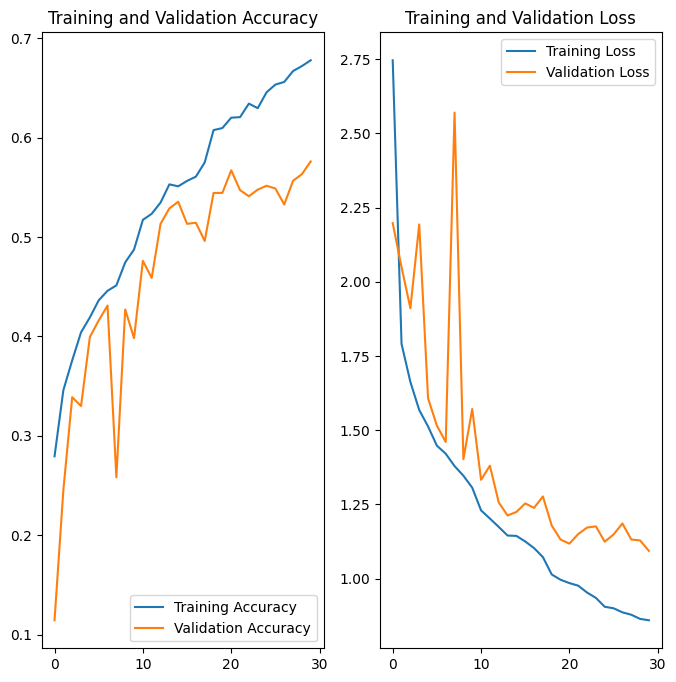

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
predicted_probabilities = model.predict(test_ds)

4/4 [==============================] - 5s 173ms/step


In [57]:
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Calculate the accuracy
accuracy = np.mean(np.equal(true_labels, predicted_classes))

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 12.71%


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes, overfitting issue is resolved now.
